
# WeRateDogs Project

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#Gathering">Gather</a></li>
<li><a href="#Assessing">Assess</a></li>
<li><a href="#Cleaning">Clean</a></li>
<li><a href="#Analyze">Analyze</a></li>
</ul>

## Gather  
- Online data (Twitter and Udacity server)
- Locally stored files(csv file)
    

In [635]:
import pandas as pd
import json
import csv
import re
import tweepy
from tweepy import OAuthHandler
import time
from urllib import request
import matplotlib 

In [636]:
#download image prediction file in url programmatically
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
 
def download_txturl(txturl):
    response = request.urlopen(txturl)
    txt = response.read()
    txtstr = str(txt)
    lines = txtstr.split('\\n')
    dest = r'image_predictions.tsv'
    op = open(dest, 'w')
    for line in lines:
        op.write(line + '\n')
    op.close()

download_txturl(url)


In [637]:
consumer_key = ''
consumer_secret = ''
access_token = ''
access_token_secret = ''


# search_favorites(consumer_key, consumer_secret, access_token, access_token_secret):
#create authentication for accessing twitter
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

#initialize Tweepy API
api = tweepy.API(auth, wait_on_rate_limit =True, wait_on_rate_limit_notify = True)
tweet_ids = df_archive.tweet_id


In [638]:
count = 0
fails_dict = {}
#save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    
    #loop through each tweet id filtered by the given archive file and write to outfile
    for tweet_id in tweet_ids:
        count += 1        
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            json.dump(tweet._json, outfile)
            outfile.write('\n')
            
        except tweepy.TweepError as e:
            fails_dict[tweet_id] = e
            pass

Rate limit reached. Sleeping for: 591
Rate limit reached. Sleeping for: 600


In [639]:
df_new = pd.DataFrame(columns=['tweet_id', 'text','retweet_count', 'favorite_count'])
with open('tweet_json.txt') as f:
    for line in f:
        status  = json.loads(line)
        tweet_id = status['id_str']
        text = status['full_text']
        retweet_count = status['retweet_count']
        favorite_count = status['favorite_count']
        df_new = df_new.append(pd.DataFrame([[tweet_id, text, retweet_count, favorite_count]],
                                        columns=['tweet_id', 'text', 'retweet_count', 'favorite_count']))
df_new = df_new.reset_index(drop=True)

In [640]:
#test
df_new.head()
df_new.shape

(2337, 4)

In [641]:
df_archive = pd.read_csv('twitter-archive-enhanced-2.csv')
df_image = pd.read_csv('image-predictions-3.tsv',  delimiter='\t')

## Assess


#### Quality
##### archive table
- Missing data for retweets and likes
- Incorrect ratings data and unnusable values
    - abnormal values
    - 75 should be 9.75
    - 1776, 420, other outliers will skew analysis
- Erroneous data types (ID, ratings, favorite_count, retweet_count, timestamp) 
- Retweets and reply-to tweets need to be removed
- Retweets and reply-to columns need to be removed
- Rows without images need to be removed
- Erroneous and missing names
- Source column is hard to understand



##### image prediction table
- results that are not dogs should be removed
- Erroneous datatypes (tweet_id)

#### Tidiness
##### archive table
- There should be one column for dog stages
- There should be one column for dog breed, and it should be connected to the archive table
- There should be one columns for rating 
- rows with more than one rating should be removed (multiple observations within one row)



## Clean

### Missing data:
- The likes and retweet counts will be added. The archive and new dataframes are combined with an inner join. This will exclude values from the archive that are no longer present. This will be easier if the tweet IDs are strings. 
    

In [642]:
df_new2 = df_new.copy()
df_archive2 = df_archive.copy()
df_image2 = df_image.copy()

In [643]:
# Data types are changed so that the archive table and newly extracted data can be combined
df_new2.tweet_id = df_new2['tweet_id'].astype('str')
df_archive2.tweet_id = df_archive2.tweet_id.astype('str')

In [644]:
#test
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [645]:
# Tables are merged with an inner join to revove any tweets not existing in both dataframes.
df_clean = df_archive2.merge(df_new2, how= 'inner', on = 'tweet_id')

In [646]:
#Test
df_clean.head(3)
df_clean2.tweet_id.duplicated().any()

False

### Unnecessary columns/data
 - Unnecessary tweets are removed by removing rows that contain a value in retweet-status and in-reply-to columns as well as those that do not contain photos. Excess columns are removed.

In [647]:
# Rows with other than null values in retweeted and in_reply_to columns are dropped from the dataset
df_clean = df_clean[(df_clean['retweeted_status_id'].isna()) & (df_clean['in_reply_to_status_id'].isna())]

In [648]:
# Test: the new and old text columns were compared to identify any differences
df_clean[df_clean.text_y != df_clean.text_x]

Empty DataFrame
Columns: [tweet_id, in_reply_to_status_id, in_reply_to_user_id, timestamp, source, text_x, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, expanded_urls, rating_numerator, rating_denominator, name, doggo, floofer, pupper, puppo, text_y, retweet_count, favorite_count]
Index: []

In [649]:
# the old text will be replaced by my newly collected text as it will be used later and I want to be sure of its correctness
df_clean.drop('text_x', axis = 1, inplace = True)

In [650]:
#the name is changed back to 'text'
df_clean.rename(columns = {'text_y': 'text'}, inplace = True)

In [651]:
#tweets without a photo are also dropped
df_clean = df_clean[df_clean.text.str.contains("https://")]

In [652]:
#test
df_clean.head()
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2090 entries, 0 to 2336
Data columns (total 19 columns):
tweet_id                      2090 non-null object
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2090 non-null object
source                        2090 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2090 non-null object
rating_numerator              2090 non-null int64
rating_denominator            2090 non-null int64
name                          2090 non-null object
doggo                         2090 non-null object
floofer                       2090 non-null object
pupper                        2090 non-null object
puppo                         2090 non-null object
text                          2090 non-null object
retweet_count                 2090 non-

In [653]:
#Unnecessary columns are removed.
df_clean.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'rating_denominator', 'in_reply_to_status_id', 'in_reply_to_user_id'],  axis =1, inplace = True )

In [654]:
# Test: check for any remaing text columns containing "RT". The resulting rows are not retweets.
df_clean[df_clean.text.str.contains('RT ')]

tweet_id                  timestamp  \
1268  708400866336894977  2016-03-11 21:15:02 +0000   
1632  683515932363329536  2016-01-03 05:11:12 +0000   
1841  675489971617296384  2015-12-12 01:38:53 +0000   
1972  672622327801233409  2015-12-04 03:43:54 +0000   

                                                 source  \
1268  <a href="http://vine.co" rel="nofollow">Vine -...   
1632  <a href="http://vine.co" rel="nofollow">Vine -...   
1841  <a href="http://twitter.com/download/iphone" r...   
1972  <a href="http://twitter.com/download/iphone" r...   

                                          expanded_urls  rating_numerator  \
1268                      https://vine.co/v/iHFqnjKVbIQ                12   
1632                      https://vine.co/v/ibvnzrauFuV                11   
1841  https://twitter.com/dog_rates/status/675489971...                10   
1972  https://twitter.com/dog_rates/status/672622327...                12   

      name doggo floofer  pupper puppo  \
1268  None  None    None    None  None   
1632  None  None    None    None  None   
1841  None  None    None    None  None   
1972  None  None    None  pupper  None   

                                                   text retweet_count  \
1268  RT if you are as ready for summer as this pup ...         10614   
1632  HEY PUP WHAT'S THE PART OF THE HUMAN BODY THAT...          3074   
1841  RT until we find this dog. Clearly a cool dog ...           619   
1972  This lil pupper is sad because we haven't foun...           499   

     favorite_count  
1268          16515  
1632           7612  
1841           1321  
1972           1305

In [655]:
#test
df_clean.shape

(2090, 13)

### Stage should be one column
  - re-extract from text, join, and then delete excess columns

In [656]:
#stages are extracted again from the text column
df_clean['stage'] = df_clean.text.str.findall(r'(doggo|floofer|pupper|puppo)')

In [657]:
#test
df_clean.shape

(2090, 14)

In [658]:
# the new stage column is a list. The few columns with double entries are separated with a comma and all values become strings. 
df_clean['stage'] = df_clean['stage'].str.join(',')

In [659]:
#test
df_clean.stage.value_counts()

                        1738
pupper                   229
doggo                     75
puppo                     27
pupper,pupper              7
doggo,pupper               5
floofer                    4
puppo,doggo                2
pupper,doggo               1
pupper,doggo,doggo         1
pupper,pupper,pupper       1
Name: stage, dtype: int64

In [660]:
# A forward slash replaces the comma for visual purposes
df_clean.stage = df_clean.stage.str.replace(',', '/')

In [661]:
#replecated stages are removed
df_clean['stage'].replace('pupper/pupper', 'pupper', inplace =True) 
df_clean['stage'].replace('pupper/doggo/doggo', 'pupper/doggo', inplace = True) 
df_clean['stage'].replace('pupper/pupper/pupper', 'pupper', inplace = True) 

In [662]:
# Excess columns are removed and results are stored in a new dataframe. 
df_clean2 = df_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis =1)

In [663]:
#test
df_clean2.stage.value_counts()

                1738
pupper           237
doggo             75
puppo             27
doggo/pupper       5
floofer            4
pupper/doggo       2
puppo/doggo        2
Name: stage, dtype: int64

### Correction of ratings
  - Re-extract ratings and remove outliers. 

In [664]:
#A regular expression is used to find all ratings
df_clean2['rating'] = df_clean2['text'].str.findall(r'(\d+/10)')

In [665]:
#test
df_clean2.rating.value_counts()

[12/10]                 483
[10/10]                 423
[11/10]                 411
[13/10]                 286
[9/10]                  152
[8/10]                   96
[7/10]                   50
[14/10]                  39
[5/10]                   32
[6/10]                   32
[3/10]                   19
[4/10]                   14
[]                       12
[2/10]                    9
[1/10]                    4
[10/10, 7/10]             3
[11/10, 8/10]             2
[10/10, 4/10]             2
[4/10, 13/10]             1
[75/10]                   1
[420/10]                  1
[10/10, 10/10]            1
[10/10, 7/10, 12/10]      1
[8/10, 11/10]             1
[5/10, 8/10]              1
[0/10]                    1
[10/10, 11/10]            1
[27/10]                   1
[9/10, 2/10]              1
[26/10]                   1
[12/10, 11/10]            1
[11/10, 10/10]            1
[10/10, 6/10]             1
[5/10, 10/10]             1
[10/10, 5/10]             1
[1776/10]           

In [666]:
# rows with multiple ratings or no ratings are removed
df_clean2 = df_clean2[(df_clean2['rating'].str.len() < 2) & (df_clean2['rating'].str.len() > 0)]

In [667]:
#test
df_clean2.shape

(2056, 11)

In [668]:
#the value is selected from the list so that it is no more in list format
df_clean2['rating'] = df_clean2['rating'].apply(lambda x: x[0])

In [669]:
#test
df_clean2.head()

tweet_id                  timestamp  \
0  892420643555336193  2017-08-01 16:23:56 +0000   
1  892177421306343426  2017-08-01 00:17:27 +0000   
2  891815181378084864  2017-07-31 00:18:03 +0000   
3  891689557279858688  2017-07-30 15:58:51 +0000   
4  891327558926688256  2017-07-29 16:00:24 +0000   

                                              source  \
0  <a href="http://twitter.com/download/iphone" r...   
1  <a href="http://twitter.com/download/iphone" r...   
2  <a href="http://twitter.com/download/iphone" r...   
3  <a href="http://twitter.com/download/iphone" r...   
4  <a href="http://twitter.com/download/iphone" r...   

                                       expanded_urls  rating_numerator  \
0  https://twitter.com/dog_rates/status/892420643...                13   
1  https://twitter.com/dog_rates/status/892177421...                13   
2  https://twitter.com/dog_rates/status/891815181...                12   
3  https://twitter.com/dog_rates/status/891689557...                13   
4  https://twitter.com/dog_rates/status/891327558...                12   

       name                                               text retweet_count  \
0   Phineas  This is Phineas. He's a mystical boy. Only eve...          8188   
1     Tilly  This is Tilly. She's just checking pup on you....          6058   
2    Archie  This is Archie. He is a rare Norwegian Pouncin...          4008   
3     Darla  This is Darla. She commenced a snooze mid meal...          8343   
4  Franklin  This is Franklin. He would like you to stop ca...          9037   

  favorite_count stage rating  
0          37545        13/10  
1          32274        13/10  
2          24314        12/10  
3          40885        13/10  
4          39086        12/10

In [670]:
# The numerator is selected
df_clean2.rating = df_clean2['rating'].str.extract('(^\d+)')

In [671]:
df_clean2.rating = df_clean2.rating.astype(float)

In [672]:
# Text: New rating column is compared to the old rating column for exploration of differences. 
df_clean2.query('rating != rating_numerator')

tweet_id                  timestamp  \
1050  740373189193256964  2016-06-08 02:41:38 +0000   
1147  722974582966214656  2016-04-21 02:25:47 +0000   
1184  716439118184652801  2016-04-03 01:36:11 +0000   
1644  682962037429899265  2016-01-01 16:30:13 +0000   
2316  666287406224695296  2015-11-16 16:11:11 +0000   

                                                 source  \
1050  <a href="http://twitter.com/download/iphone" r...   
1147  <a href="http://twitter.com/download/iphone" r...   
1184  <a href="http://twitter.com/download/iphone" r...   
1644  <a href="http://twitter.com/download/iphone" r...   
2316  <a href="http://twitter.com/download/iphone" r...   

                                          expanded_urls  rating_numerator  \
1050  https://twitter.com/dog_rates/status/740373189...                 9   
1147  https://twitter.com/dog_rates/status/722974582...                 4   
1184  https://twitter.com/dog_rates/status/716439118...                50   
1644  https://twitter.com/dog_rates/status/682962037...                 7   
2316  https://twitter.com/dog_rates/status/666287406...                 1   

          name                                               text  \
1050      None  After so many requests, this is Bretagne. She ...   
1147      None  Happy 4/20 from the squad! 13/10 for all https...   
1184  Bluebert  This is Bluebert. He just saw that both #Final...   
1644    Darrel  This is Darrel. He just robbed a 7/11 and is i...   
2316        an  This is an Albanian 3 1/2 legged  Episcopalian...   

     retweet_count favorite_count stage  rating  
1050         13976          36027          14.0  
1147          1639           4220          13.0  
1184           219           2438          11.0  
1644         17564          38218          10.0  
2316            63            141           9.0

In [673]:
#The original rating numerator column is removed
df_clean2.drop('rating_numerator', axis =1, inplace =True)

In [674]:
# Outliers are removed
df_clean2 = df_clean2.query('rating <20')

In [675]:
#test
df_clean2.shape

(2051, 10)

### Breeds should be one column
 - The image prediction data set is cleaned so that there is one value per tweet, then added to the main table

In [676]:
#new data frames are created that will designate the most likely dog breed for each tweet. Predictions where no result was a 
#dog breed are removed. 
df_1 = df_image2.query('p1_dog == True')
df_2 = df_image2.query('p1_dog != True & p2_dog == True')
df_3 = df_image2.query('p1_dog != True & p2_dog != True & p3_dog == True')

df_1['breed'] = df_1['p1']
df_2['breed'] = df_2['p2']
df_3['breed'] = df_3['p3']

C:\Users\Summer\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\Summer\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Summer\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/inde

In [677]:
#test
len(df_1) + len(df_2) + len(df_3)
len(df_image)

2075

In [678]:
# The new dataframes are concatenated into one. 
image_clean = pd.concat([df_1, df_2, df_3], axis=0, join='outer', join_axes=None, ignore_index=True,
          keys=None, levels=None, names=None, verify_integrity=False,
          copy=True)
# All columns except the new breed column and the twitter ID are removed. 
image_clean = image_clean[['tweet_id','breed']]

In [679]:
#test
image_clean.head()

tweet_id                   breed
0  666020888022790149  Welsh_springer_spaniel
1  666029285002620928                 redbone
2  666033412701032449         German_shepherd
3  666044226329800704     Rhodesian_ridgeback
4  666049248165822465      miniature_pinscher

In [680]:
# The tweet_id data types are changed to strings so the tables can be merged
image_clean = image_clean.astype(str, copy=True)
# The dataframes are merged so that there is now a breed column in the main dataframe. Tweets with no reasonable prediction will
#now have null values.
df_clean2 = df_clean2.merge(image_clean, how = 'left', on = 'tweet_id')

In [681]:
#test
df_clean2.info()
df_clean2.tweet_id.duplicated().any()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2051 entries, 0 to 2050
Data columns (total 11 columns):
tweet_id          2051 non-null object
timestamp         2051 non-null object
source            2051 non-null object
expanded_urls     2051 non-null object
name              2051 non-null object
text              2051 non-null object
retweet_count     2051 non-null object
favorite_count    2051 non-null object
stage             2051 non-null object
rating            2051 non-null float64
breed             1627 non-null object
dtypes: float64(1), object(10)
memory usage: 192.3+ KB


False

### Missing names and name corrections
 - Some of the names were recovered from the text by searching with an additional regular expression. Then erroneous names were corrected one at a time. Then common name errors such as "a" were replaced with "None".

In [682]:
#test
df_clean2.name.value_counts()

None        580
a            54
Lucy         11
Charlie      10
Cooper       10
Oliver       10
Penny         9
Tucker        9
Lola          8
Sadie         8
the           8
Winston       8
Toby          7
Daisy         7
Oscar         6
Bella         6
Stanley       6
Koda          6
Bo            6
Jax           6
an            6
Bailey        6
Chester       5
Leo           5
Buddy         5
Milo          5
Bentley       5
Louis         5
Rusty         5
Scout         5
           ... 
Derby         1
Tedrick       1
Ralph         1
Eevee         1
Hero          1
Spencer       1
Henry         1
Suki          1
Timison       1
Rueben        1
Lipton        1
Dietrich      1
Clarkus       1
Ginger        1
Brockly       1
Tilly         1
Kollin        1
Stephan       1
Obi           1
Jeffrie       1
Tino          1
Randall       1
Gin           1
Herb          1
Ike           1
Chompsky      1
Champ         1
Mac           1
Jordy         1
Link          1
Name: name, Length: 941,

In [683]:
# Visual analysis showed that 23 missing names are preceded with "named". Additional names are extracted from the text into a new column
df_clean2['names'] = df_clean2['text'].str.extract(r'named (\w+)')

In [684]:
# the old name values are added to the new names columns
df_clean2['names'].fillna(df_clean2['name'], inplace =True)

In [685]:
#Many of the erroneous names have been removed by the other filtering processes above. The ones remaining are "quite" and "a". 
#The dog with the name "a" has an instgram name of "Puffie the Chow". 

df_clean2.loc[df_clean2['tweet_id'] == '881536004380872706', 'names'] = "puffie_the_chow"
df_clean2.loc[df_clean2['tweet_id'] == '765395769549590528', 'names'] = "Zoey"
df_clean2.loc[df_clean2['tweet_id'] == '828650029636317184', 'names'] = "Grace"
df_clean2.loc[df_clean2['name'] == 'a', 'names'] = "None"
df_clean2.loc[df_clean2['name'] == 'an', 'names'] = "None"
df_clean2.loc[df_clean2['name'] == 'quite', 'names'] = "None"
df_clean2.loc[df_clean2['name'] == 'such', 'names'] = "None"
df_clean2.loc[df_clean2['name'] == 'just', 'names'] = "None"
df_clean2.loc[df_clean2['name'] == 'unacceptable', 'names'] = "None"
df_clean2.loc[df_clean2['name'] == 'the', 'names'] = "None"

In [686]:
df_clean2.drop('name', axis = 1, inplace = True)

In [687]:
#test
df_clean2.names.value_counts()

None        653
Lucy         11
Cooper       10
Oliver       10
Charlie      10
Tucker        9
Penny         9
Lola          8
Sadie         8
Winston       8
Toby          7
Daisy         7
Jax           6
Koda          6
Bella         6
Bo            6
Stanley       6
Oscar         6
Bailey        6
Milo          5
Leo           5
Chester       5
Dave          5
Scout         5
Bentley       5
Louis         5
Buddy         5
Rusty         5
Derek         4
Jeffrey       4
           ... 
Derby         1
Tedrick       1
Ralph         1
Eevee         1
Hero          1
Spencer       1
light         1
Suki          1
Timison       1
Rueben        1
Lipton        1
Dietrich      1
Clarkus       1
Ginger        1
Brockly       1
Tilly         1
Kollin        1
Stephan       1
Obi           1
Jeffrie       1
Tino          1
Randall       1
Gin           1
Herb          1
Ike           1
Chompsky      1
Champ         1
Mac           1
Jordy         1
Link          1
Name: names, Length: 936

### Miscelaneous cleaning 
 - 'source' value simplification, datatype corrections, addition of days of the week column

In [688]:
#source columns are simplified
df_clean2.loc[df_clean2['source'] == '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', 'source'] = 'iPhone'
df_clean2.loc[df_clean2['source'] == '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>', 'source'] = 'twitter_web_client'
df_clean2.loc[df_clean2['source'] == '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>', 'source'] = 'vine_make_a_scene'
df_clean2.loc[df_clean2['source'] == '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>', 'source'] = 'tweet_deck'

In [689]:
#value_counts()
df_clean2.source.value_counts()

iPhone                1923
vine_make_a_scene       91
twitter_web_client      28
tweet_deck               9
Name: source, dtype: int64

In [690]:
#the remaining incorrect datatypes are changed to allow for analysis
df_clean2.retweet_count = df_clean2.retweet_count.astype(int)
df_clean2.favorite_count = df_clean2.favorite_count.astype(int)
df_clean2.stage = df_clean2.stage.astype('category')
df_clean2.timestamp = pd.to_datetime(df_clean2['timestamp'])
df_clean2.source = df_clean2.source.astype('category')          

In [691]:
# Another column is produced with the day of the week for purposes of analysis
import datetime as dt
df_clean2['day_of_week'] = df_clean2['timestamp'].dt.dayofweek
df_clean2.day_of_week = df_clean2.day_of_week.astype('int')
df_clean2.day_of_week.value_counts()

0    342
1    307
2    304
3    287
4    284
5    267
6    260
Name: day_of_week, dtype: int64

In [692]:
df_clean2.to_csv('twitter_archive_master.csv')

In [693]:
#Test
df_clean2.shape

(2051, 12)

# Analyse

In [694]:
import seaborn
import statsmodels.api as sm
import matplotlib.pyplot as plt
df_clean2.describe()

retweet_count  favorite_count       rating  day_of_week
count    2051.000000     2051.000000  2051.000000  2051.000000
mean     2703.535349     8767.448562    10.621160     2.831302
std      4718.260584    12667.015207     2.150739     2.005314
min        11.000000       76.000000     0.000000     0.000000
25%       596.500000     1941.000000    10.000000     1.000000
50%      1307.000000     3994.000000    11.000000     3.000000
75%      3073.500000    10916.500000    12.000000     5.000000
max     82462.000000   162144.000000    14.000000     6.000000

In [695]:
df_clean3 = df_clean2.copy()
df_clean3['intercept'] = 1

lm = sm.OLS(df_clean3['rating'], df_clean3[['intercept', 'retweet_count']])
res = lm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     199.9
Date:                Mon, 13 May 2019   Prob (F-statistic):           2.29e-43
Time:                        14:17:17   Log-Likelihood:                -4385.0
No. Observations:                2051   AIC:                             8774.
Df Residuals:                    2049   BIC:                             8785.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept        10.2538      0.052    196.203      0.000      10.151      10.356
retweet_count     0.0001   9.61e-06     14.137      0.000       0.000       0.000
==============================================================================
Omnibus:                      666.320   Durbin-Watson:                   1.649
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2086.922
Skew:                          -1.648   Prob(JB):                         0.00
Kurtosis:                       6.682   Cond. No.                     6.27e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.27e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0.5, 1.0, 'Retweet and Favorite Count')

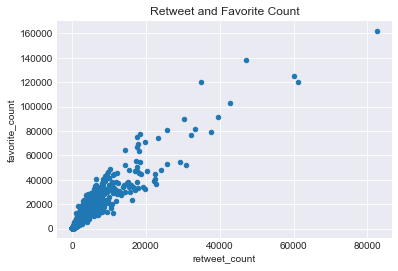

In [696]:
plt.style.use('seaborn-darkgrid')
df_clean2.plot(x = 'retweet_count', y = 'favorite_count', kind = 'scatter')
plt.title('Retweet and Favorite Count')

In [697]:
lm = sm.OLS(df_clean3['favorite_count'], df_clean3[['intercept', 'retweet_count']])
res = lm.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         favorite_count   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                 1.252e+04
Date:                Mon, 13 May 2019   Prob (F-statistic):               0.00
Time:                        14:17:18   Log-Likelihood:                -20274.
No. Observations:                2051   AIC:                         4.055e+04
Df Residuals:                    2049   BIC:                         4.056e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept      2039.1829    120.944     16.861      0.000    1801.997    2276.369
retweet_count     2.4887      0.022    111.877      0.000       2.445       2.532
==============================================================================
Omnibus:                      557.737   Durbin-Watson:                   0.764
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12496.834
Skew:                           0.736   Prob(JB):                         0.00
Kurtosis:                      15.003   Cond. No.                     6.27e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.27e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0.5, 1.0, 'Rating and Favorite Count')

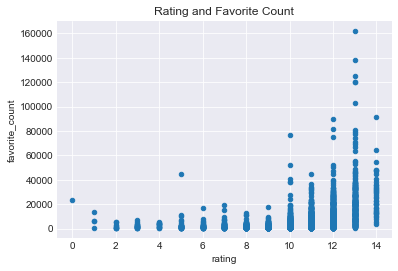

In [698]:
df_clean2.plot(x = 'rating', y = 'favorite_count', kind = 'scatter')
plt.title('Rating and Favorite Count')

Text(0.5, 1.0, 'Ratings Over Time')

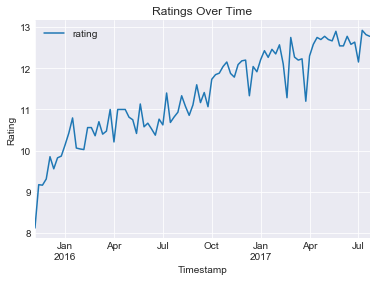

In [699]:
dftime = df_clean2
dftime.timestamp = dftime.timestamp.values.astype('<M8[W]')

dftime2 = dftime.groupby('timestamp').mean()[['rating']]
dftime2.plot()
plt.xlabel('Timestamp')
plt.ylabel('Rating')
plt.title('Ratings Over Time')

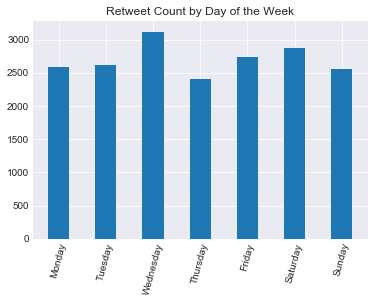

In [700]:
df5 = df_clean2.groupby('day_of_week').mean()[['retweet_count']]
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
p1 = plt.bar(df5.index, df5.retweet_count, width)
#plt.xticks(days)
plt.xticks(np.arange(7), ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'), rotation = 75)
plt.title('Retweet Count by Day of the Week')
plt.show()



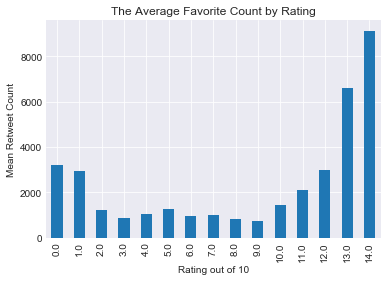

In [701]:
df2 = df_clean2.groupby('rating').mean()[['retweet_count']]
df2.plot(kind = 'bar')
plt.ylabel('Mean Retweet Count')
plt.xlabel('Rating out of 10')
plt.title('The Average Favorite Count by Rating')
plt.legend().set_visible(False)

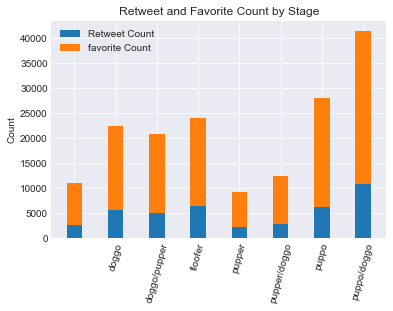

retweet_count  favorite_count
stage                                      
                2549.467213     8393.221311
doggo           5660.040541    16742.891892
doggo/pupper    5100.200000    15688.600000
floofer         6436.500000    17646.250000
pupper          2296.393013     6944.235808
pupper/doggo    2814.500000     9527.000000
puppo           6197.074074    21774.037037

In [702]:
import numpy as np
df4 = df_clean2.groupby('stage').mean()[['retweet_count', 'favorite_count']]


width = 0.38       
p1 = plt.bar(df4.index, df4.retweet_count, width)
p2 = plt.bar(df4.index, df4.favorite_count, width, bottom= df4.retweet_count)

plt.ylabel('Count')
plt.title('Retweet and Favorite Count by Stage')
plt.xticks(df4.index, rotation=75)
plt.legend((p1[0], p2[0]), ('Retweet Count', 'favorite Count'))

plt.show()

df4.head(7)

In [703]:
breed = df_clean2.groupby( 'breed').count().nlargest(10, 'tweet_id')
breed.reset_index(inplace = True)
df_breed= df_clean2[df_clean2['breed'].isin(breed['breed'])]

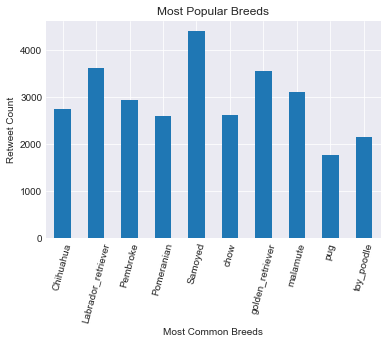

In [704]:
df_breed1 = df_breed.groupby('breed').mean()[['retweet_count']]
df_breed1.plot(kind = 'bar')
plt.xlabel('Most Common Breeds')
plt.ylabel('Retweet Count')
plt.title('Most Popular Breeds')
plt.xticks( rotation=75)
plt.legend().set_visible(False)

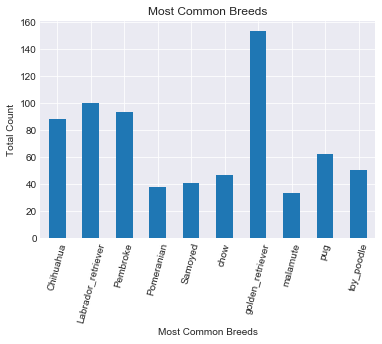

In [705]:
df_breed2 = df_breed.set_index('breed')
df_breed3 = df_breed.groupby('breed').count()[['tweet_id']]
df_breed3.plot(kind = 'bar')
plt.xticks(rotation = 75)
plt.xlabel('Most Common Breeds')
plt.ylabel('Total Count')
plt.title('Most Common Breeds')
plt.legend().set_visible(False)

In [706]:
df_clean2[df_clean2.favorite_count== df_clean2.favorite_count.max()]

tweet_id  timestamp  source  \
812  744234799360020481 2016-06-16  iPhone   

                                         expanded_urls  \
812  https://twitter.com/dog_rates/status/744234799...   

                                                  text  retweet_count  \
812  Here's a doggo realizing you can stand in a po...          82462   

     favorite_count  stage  rating               breed names  day_of_week  
812          162144  doggo    13.0  Labrador_retriever  None            5

In [707]:
df_clean2.shape

(2051, 12)

In [708]:
df_clean2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2051 entries, 0 to 2050
Data columns (total 12 columns):
tweet_id          2051 non-null object
timestamp         2051 non-null datetime64[ns]
source            2051 non-null category
expanded_urls     2051 non-null object
text              2051 non-null object
retweet_count     2051 non-null int32
favorite_count    2051 non-null int32
stage             2051 non-null category
rating            2051 non-null float64
breed             1627 non-null object
names             2051 non-null object
day_of_week       2051 non-null int32
dtypes: category(2), datetime64[ns](1), float64(1), int32(3), object(5)
memory usage: 156.8+ KB
